<a href="https://colab.research.google.com/github/VivekGangurde94/Mlproject/blob/main/AF_formation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [33]:
src_path='drive/MyDrive/AF_Formation'

train_path=os.path.join(src_path,'train')
val_path=os.path.join(src_path,'validation')
kick_off_tr, kick_off_val = os.path.join(train_path,'Kick Off'),os.path.join(val_path,'Kick Off')
Right_Tri_tr, Right_Tri_val = os.path.join(train_path,'Right Tri'),os.path.join(val_path,'Right Tri')
Extra_Point_tr, Extra_Point_val = os.path.join(train_path,'Extra Point'),os.path.join(val_path,'Extra Point')
Double_wing_Balanced_tr, Double_wing_Balanced_val = os.path.join(train_path,'Double wing Balanced'),os.path.join(val_path,'Double wing Balanced')
Double_Wing_tr, Double_Wing_val = os.path.join(train_path,'Double Wing'),os.path.join(val_path,'Double Wing')

In [34]:
training_df=len(os.listdir(kick_off_tr))+len(os.listdir(Right_Tri_tr))+len(os.listdir(Extra_Point_tr))+len(os.listdir(Double_wing_Balanced_tr))+len(os.listdir(Double_Wing_tr))
valid_df=len(os.listdir(kick_off_val))+len(os.listdir(Right_Tri_val))+len(os.listdir(Extra_Point_val))+len(os.listdir(Double_wing_Balanced_val))+len(os.listdir(Double_Wing_val))
test_path=os.path.join(src_path,'test')

FINE_TUNING_EPOCHS = 4
TRAINING_EPOCHS = 10
BATCH_SIZE = 16


Data Generators

In [6]:
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

In [35]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = False,
                         zoom_range      = 0.05,
                         rotation_range  = 25,
                         fill_mode='nearest')


# creating the data flow object
train_generator= gen.flow_from_directory(directory=train_path,
                                    batch_size = BATCH_SIZE,
                                    class_mode='categorical',
                                    color_mode = "rgb",
                                    shuffle = True,
                                    seed = 42,
                                    target_size=(256,256))

Found 269 images belonging to 5 classes.


In [76]:
# Data agumentation and pre-processing using tensorflow
test_gen = ImageDataGenerator(rescale=1./255.)
validation_generator = test_gen.flow_from_directory(directory=val_path,
                                                    batch_size  = BATCH_SIZE,
                                                    class_mode  ='categorical',
                                                    color_mode  ="rgb",
                                                    shuffle     =False,
                                                    seed        = 42,
                                                    target_size =(256,256))

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 color_mode  = "rgb",
                                                 target_size = (256, 256),
                                                 class_mode  = None)

Found 45 images belonging to 5 classes.
Found 19 images belonging to 5 classes.


In [9]:
class_names = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in class_names.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Double Wing
1 : Double wing Balanced
2 : Extra Point
3 : Kick Off
4 : Right Tri


In [10]:
def plot_images(img, true_labels, predictions=None):
    num_images = len(img)
    rows = (num_images + 3) // 4  # Calculate the number of rows needed

    plt.figure(figsize=(10, 10))

    for i in range(num_images):
        plt.subplot(rows, 4, i + 1)
        plt.imshow(img[i])
        plt.axis('off')

        if (predictions is not None):
            if true_labels is not None:
                plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
            else:
                plt.title("{} {:.1f}%".format(class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            if true_labels is not None:
                plt.title(class_names[np.argmax(true_labels[i])])

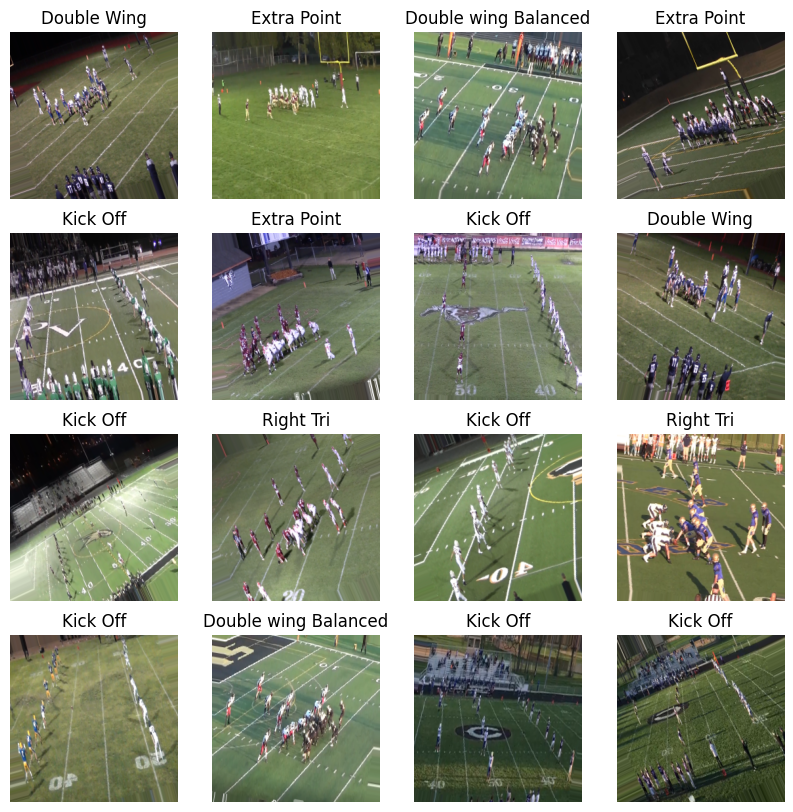

In [11]:
x,y = next(train_generator)
plot_images(x,y)

In [12]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')

    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    ax.set_title(title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

In [15]:
from tensorflow.keras.models import Model

def create_model(base_model):

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(len(class_names), activation='softmax')(x)

    model = Model(base_model.inputs, outputs)

    return model

In [16]:
def fit_model(model, base_model, epochs, fine_tune = 0):

    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    # early stopping call back

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.

    print("Unfreezing number of layers in base model = ", fine_tune)

    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    # categorical cross entropy is taken since its used as a loss function for
    # multi-class classification problems where there are two or more output labels.
    # using Adam optimizer for better performance
    # other optimizers such as sgd can also be used depending upon the model

    # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early])

    return history

Inception

In [17]:
# load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (256, 256, 3)
                     )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
inception_model = create_model(inception_base_model)
#inception_model.summary()
history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)

Unfreezing number of layers in base model =  0
Epoch 1/10
17/17 [==============================] - 236s 13s/step - loss: 1.7207 - accuracy: 0.3234 - val_loss: 1.3093 - val_accuracy: 0.4222
Epoch 2/10
17/17 [==============================] - 198s 12s/step - loss: 1.4262 - accuracy: 0.3717 - val_loss: 1.2539 - val_accuracy: 0.4667
Epoch 3/10
17/17 [==============================] - 195s 11s/step - loss: 1.3330 - accuracy: 0.4721 - val_loss: 1.2741 - val_accuracy: 0.4444
Epoch 4/10
17/17 [==============================] - 208s 12s/step - loss: 1.2817 - accuracy: 0.4572 - val_loss: 1.0796 - val_accuracy: 0.5556
Epoch 5/10
17/17 [==============================] - 209s 12s/step - loss: 1.1614 - accuracy: 0.5093 - val_loss: 0.8966 - val_accuracy: 0.6667
Epoch 6/10
17/17 [==============================] - 208s 12s/step - loss: 1.1514 - accuracy: 0.5167 - val_loss: 0.8810 - val_accuracy: 0.5778
Epoch 7/10
17/17 [==============================] - 209s 12s/step - loss: 0.9676 - accuracy: 0.6097 -

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

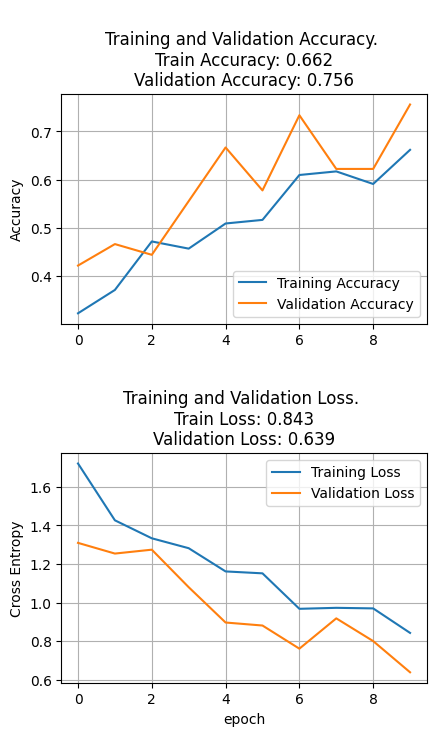

In [19]:
plot_history(history)

In [20]:
accuracy_score = inception_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

3/3 [==============================] - 34s 9s/step - loss: 0.6387 - accuracy: 0.7556
[0.6387152671813965, 0.7555555701255798]
Accuracy: 75.56%
Loss: 0.639


In [21]:
# Perform predictions to allow computation of the confusion matrix later on

validation_generator.reset()
inception_val_preds = inception_model.predict(validation_generator)
inception_val_pred_classes = np.argmax(inception_val_preds, axis=1)

3/3 [==============================] - 39s 8s/step


In [22]:
# Perform predictions to allow computation of the confusion matrix later on

test_generator.reset()
inception_test_preds = inception_model.predict(test_generator)
inception_test_pred_classes = np.argmax(inception_test_preds, axis=1)

2/2 [==============================] - 10s 7s/step


In [26]:
from tensorflow.keras.models import load_model

inception_model.save('/content/drive/MyDrive/saved models/AF_Formation.hdf5 ')

In [51]:
import numpy as np
predictions = inception_model.predict(validation_generator)

# Get the predicted class for each image
predicted_classes = np.argmax(predictions, axis=1)

print('Predicted classes:', predicted_classes)
print('True labels:', validation_generator.classes)

3/3 [==============================] - 33s 8s/step
Predicted classes: [0 0 0 2 1 0 0 0 4 0 4 0 1 0 0 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4 2
 4 4 4 4 0 0 4 3]
True labels: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4
 4 4 4 4 4 4 4 4]


In [53]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('Accuracy:\n', accuracy_score(validation_generator.classes, predicted_classes))

Accuracy:
 0.7555555555555555


In [77]:
predictions = inception_model.predict(test_generator)

2/2 [==============================] - 12s 2s/step


In [78]:
test_loss, test_accuracy = inception_model.evaluate(test_generator, batch_size = BATCH_SIZE )

2/2 [==============================] - 1s 100ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


In [79]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

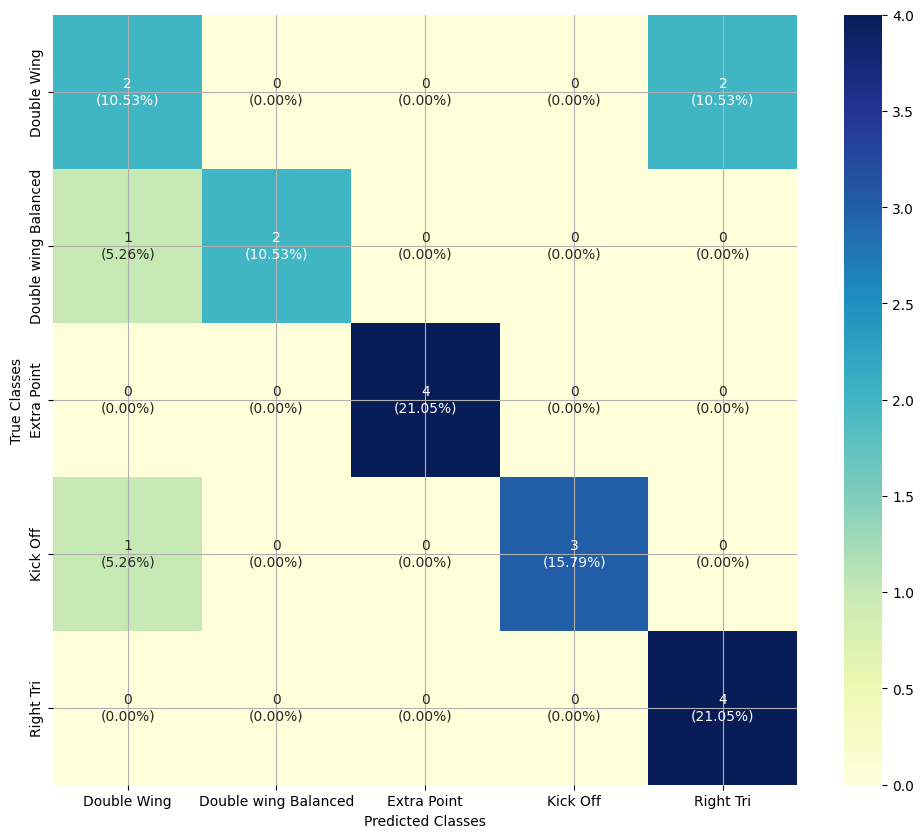

In [80]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(5,5)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=class_names.values(), yticklabels=class_names.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [81]:
print(classification_report(y_true, y_pred, target_names=class_names.values()))

                      precision    recall  f1-score   support

         Double Wing       0.50      0.50      0.50         4
Double wing Balanced       1.00      0.67      0.80         3
         Extra Point       1.00      1.00      1.00         4
            Kick Off       1.00      0.75      0.86         4
           Right Tri       0.67      1.00      0.80         4

            accuracy                           0.79        19
           macro avg       0.83      0.78      0.79        19
        weighted avg       0.82      0.79      0.79        19



In [82]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [83]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

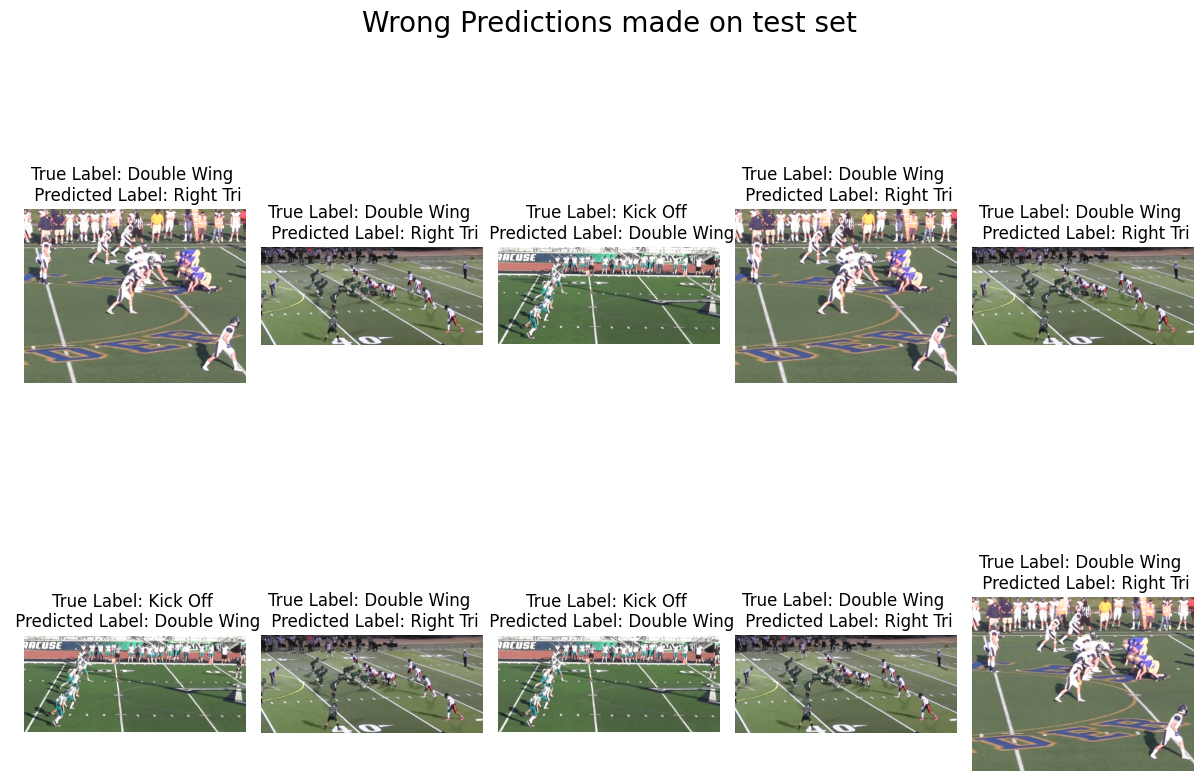

In [84]:
import cv2
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = class_names[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = class_names[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_path, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()